This demonstrates all the steps in my candidate selection before conducting visual inspection

In [1]:
import numpy as np
import splat
import wisps.data_analysis as wispd
from wisps.data_analysis import selection_criteria as sel_crt
import shapey
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import wisps

import matplotlib as mpl


import random
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#withnans=wisps.datasets['highsnr']
#wihtoutnans=

In [3]:
comb0=pd.read_hdf(wisps.COMBINED_PHOTO_SPECTRO_FILE, key='new_stars')

In [4]:
alldata=pd.read_hdf(wisps.COMBINED_PHOTO_SPECTRO_FILE, key='all_phot_spec_data')

In [5]:
star_ids=alldata[alldata['class_star'] !=0]

In [6]:
comb0['grism_id']=comb0.grism_id.apply(lambda x: str(x).lower())

In [7]:
comb=comb0[comb0.grism_id.isin(star_ids.grism_id.values)]

In [8]:
stars=wisps.Annotator.reformat_table(wisps.datasets['stars'])

In [9]:
from tqdm import tqdm

In [10]:
st=stars[stars.grism_id.isin(comb.grism_id.values)]

In [11]:
spex=wisps.Annotator.reformat_table(wisps.datasets['spex'])

In [12]:
comb=comb.reset_index(drop=True)

In [13]:
comb=comb.iloc[(comb[wisps.INDEX_NAMES]).dropna().index]
comb=comb.iloc[(comb[wisps.INDEX_NAMES]).dropna().index]
comb=comb.loc[:,~comb.columns.duplicated()]
comb=wisps.Annotator.reformat_table(comb)
comb=comb.drop_duplicates(subset='grism_id')

for k in wisps.INDEX_NAMES:
    fig, ax=plt.subplots()
    
    #plt.hist(spex[k].apply(np.log10).replace((np.inf, -np.inf), np.nan).dropna(), bins=32, histtype='step', normed=True)
    plt.hist(comb[k].apply(np.log10).replace((np.inf, -np.inf), np.nan).dropna(), bins=32, histtype='step', normed=True)
    plt.hist(st[k].apply(np.log10).replace((np.inf, -np.inf), np.nan).dropna(), bins=32, histtype='step', normed=True, color='k')
    
    ax.set_title(r'$'+str(k.split(' ')[0])+'$', fontsize=18)
    

In [14]:
comb[wisps.INDEX_NAMES]=(comb[wisps.INDEX_NAMES].applymap(float))

In [15]:
cands=pd.read_pickle(wisps.OUTPUT_FILES+'/true_spectra_cands.pkl')

In [16]:
cands[wisps.INDEX_NAMES]=(comb[comb.grism_id.isin(cands['grism_id'])])[wisps.INDEX_NAMES]

In [17]:
dt=comb[(stars.f_test< 0.4) &(comb.snr2>=3.)].reset_index(drop=True)

In [18]:
gbhio=sel_crt.save_criteria(conts=dt)

  0%|          | 0/120 [00:00<?, ?it/s]

(2460, 32) (120, 32)


100%|██████████| 120/120 [01:33<00:00,  1.29it/s]


In [19]:
crts=sel_crt.crts_from_file()

In [20]:
contamns=pd.DataFrame([ x.contamination for x in crts.values()])
compls=pd.DataFrame([ x.completeness for x in crts.values()])

In [21]:
compls.min()

L0-L5        0.945559
L5-T0        0.942771
M7-L0        0.953923
T0-T5        0.950413
T5-T9        0.934066
subdwarfs    0.933333
trash        0.946988
Y dwarfs     0.804878
dtype: float64

In [22]:
contamns.index=[x for x in crts.keys()]
compls.index=[x for x in crts.keys()]

In [23]:
1/100

0.01

In [24]:
contamns.style.apply(lambda x: ["background-color: #7FDBFF" 
                          if (i >= 0 and (v < 0.1 
                                          and v > 0. )) 
                          else "" for i, v in enumerate(x)], axis = 1)

,L0-L5,L5-T0,M7-L0,T0-T5,T5-T9,subdwarfs,trash,Y dwarfs
H_2O-1/J-Cont H_2O-2/H_2O-1,0.029571,0.098430,0.081319,0.001661,0.000166,0.223025,0.244206,0.000249
H_2O-1/J-Cont H-cont/H_2O-1,0.112717,0.127835,0.158402,0.032146,0.006396,0.221198,0.273528,0.004984
H_2O-1/J-Cont CH_4/H_2O-1,0.115873,0.130991,0.174765,0.029072,0.001080,0.252762,0.302849,0.001329
H_2O-1/J-Cont H_2O-2/J-Cont,0.036886,0.100142,0.082283,0.001919,0.000167,0.303346,0.263623,0.000334
H_2O-1/J-Cont H-cont/J-Cont,0.085204,0.111241,0.128432,0.027038,0.000835,0.148961,0.229408,0.002337
H_2O-1/J-Cont CH_4/J-Cont,0.089043,0.117917,0.139781,0.034048,0.001335,0.173329,0.253943,0.000250
H_2O-1/J-Cont H-cont/H_2O-2,0.122794,0.131999,0.272443,0.046871,0.012077,0.536103,0.412212,0.006081
H_2O-1/J-Cont CH_4/H_2O-2,0.113673,0.118233,0.266700,0.037666,0.012077,0.526391,0.407989,0.005996
H_2O-1/J-Cont CH_4/H-Cont,0.076462,0.099923,0.192996,0.045980,0.001199,0.359020,0.273739,0.000000
H_2O-1/J-Cont H_2O-1+H_2O-2/J-Cont,0.070022,0.120110,0.130326,0.013290,0.000665,0.446050,0.361824,0.000332


In [25]:
crts['H_2O-1/J-Cont H_2O-2/H_2O-1']

index-index space of H_2O-1/J-Cont H_2O-2/H_2O-1

In [26]:
#

In [27]:
to_use={'H_2O-1/J-Cont H_2O-2/H_2O-1':'L0-L5',
        'H_2O-1+H_2O-2/J-Cont H_2O-1+H_2O-2/H-Cont':'L5-T0' ,
        'H_2O-1/J-Cont H_2O-2/J-Cont':'M7-L0',
        'H_2O-1+H_2O-2/J-Cont H_2O-2+CH_4/J-Cont': 'T0-T5',
        'H_2O-2/J-Cont H_2O-1+CH_4/H-Cont': 'T5-T9',
        'H-cont/H_2O-2 H_2O-1+CH_4/H-Cont': 'Y dwarfs',
        'H_2O-1/J-Cont H-cont/J-Cont': 'subdwarfs'}

In [28]:
len(to_use)

7

In [29]:
def box_parameters(idx, spt_range):
    bs=idx.shapes
    b=[x for x in bs if x.shape_name==spt_range][0]
    print ('{}  {} m: {} b: {} s:{}, comp : {}, cont: {}'.format(spt_range, idx,  round(b.coeffs[0], 2), round(b.coeffs[1], 2), round(b.scatter, 2), round(idx.completeness[spt_range], 2),  round(idx.contamination[spt_range], 3)))

In [30]:
spex_df=wisps.Annotator.reformat_table(wisps.datasets['spex']).reset_index(drop=True)
manj=wisps.Annotator.reformat_table(wisps.datasets['manjavacas']).reset_index(drop=True)
schn=wisps.Annotator.reformat_table(wisps.datasets['schneider']).reset_index(drop=True)

In [31]:
ydwarfs=(manj[manj['spt'].apply(wisps.make_spt_number)>38].append(schn)).reset_index(drop=True)

In [32]:
cands['spt']=cands.spectra.apply(lambda x: x.spectral_type)

In [33]:
cands_dff=(dt[dt.grism_id.isin(cands.grism_id)]).reset_index(drop=True)

In [34]:
cands_dff['spt']=cands['spt']

In [35]:
cands_dff=wisps.Annotator.reformat_table(cands_dff)

In [36]:
import pickle
#save the random forest
output_file=wisps.OUTPUT_FILES+'/best_indices_to_use.pkl'
with open(output_file, 'wb') as file:
    pickle.dump(to_use,file)

In [37]:
#dt

In [38]:
fp={}

In [39]:
cands_dff.grism_id=cands_dff.grism_id.apply(lambda x: x.lower())

In [40]:
stars.grism_id=stars.grism_id.apply(lambda x: x.lower())

In [41]:
cx=cands_dff[cands_dff.grism_id.isin(stars.grism_id)]

In [42]:
cy=stars[stars.grism_id.isin(cx.grism_id)]

In [43]:
idx=crts['H_2O-1/J-Cont H_2O-2/H_2O-1']

In [44]:
def plot_index_box(index_name, box_name, ax):
    
    #get the index and the box
    idx=crts[index_name]
    bx=[x for x in idx.shapes if x.shape_name==box_name][0]
    
    xkey=idx.xkey
    ykey=idx.ykey

    to_use_df=spex_df
    if box_name.lower()=='y dwarfs':
        to_use_df=ydwarfs
    if box_name.lower()=='subdwarfs':
        to_use_df=wisps.Annotator.reformat_table(idx.subdwarfs)
        to_use_df['spt']=17

    ax.scatter(dt[xkey].apply(float).values, dt[ykey].apply(float).values, marker='o', s=10., facecolors='none', edgecolors='#AAAAAA')
    
    
    cands_slctd, cands_bools=bx._select(np.array([cands_dff[xkey].values,cands_dff[ykey].values]))
   
    trash_slctd, trsh_bools=bx._select(np.array([dt[xkey].values, dt[ykey].values]))
    
    
    cands_in_that_class_bool=(cands_dff[ cands_bools]).spt.apply(lambda x: wisps.is_in_that_classification(x, box_name))
    
    spexs_slctd_in_that_class_bool= (to_use_df).spt.apply(lambda x: wisps.is_in_that_classification(x, box_name))
    
    if box_name.lower()=='subdwarfs':
         spexs_slctd_in_that_class_bool=np.ones(len(to_use_df), dtype=bool)
    
    
    
    
    cands_in_that_class=np.array([cands_slctd[0][cands_in_that_class_bool], cands_slctd[1][cands_in_that_class_bool]])
    
    spexs_slctd_in_that_class=np.array([to_use_df[xkey][spexs_slctd_in_that_class_bool], to_use_df[ykey][spexs_slctd_in_that_class_bool]])

    ax.scatter(spexs_slctd_in_that_class[0], spexs_slctd_in_that_class[1], facecolors='#0074D9',  label='SpeX', s=10.)
    
    ax.scatter(cands_dff[xkey], cands_dff[ykey], marker='x', facecolors='#111111', s=10.)
    
    
    ax.scatter( cands_in_that_class[0],    cands_in_that_class[1], marker='x', facecolors='#FF851B', s=10, edgecolors='#2ECC40', label='candidates')
    
    
    bx.color='#2ECC40'
    bx.alpha=.1
    bx.plot(ax=ax, only_shape=True, highlight=False)
    
    
    #ax.set_xlabel(r'$'+str(idx.name.split(' ')[0])+'$', fontsize=18)
    #ax.set_ylabel(r'$'+str(idx.name.split(' ')[1])+'$', fontsize=18)
    
    ax.set_title(box_name, fontsize=18)
    
    xbuffer=np.nanstd(to_use_df[[xkey,ykey]])
    
    ax.set_xlim([ bx.xrange[0]-0.5*abs(np.ptp(bx.xrange)), bx.xrange[1]+0.5*abs(np.ptp(bx.xrange))])
    ax.set_ylim([ bx.yrange[0]-0.5*abs(np.ptp(bx.yrange)), bx.yrange[1]+0.5*abs(np.ptp(bx.yrange))])
    
    ax.minorticks_on()
    

    if (trash_slctd.shape[1])==0:
        fprate=0.0
    else:
        fprate=(trash_slctd.shape[1]- cands_slctd.shape[1])/trash_slctd.shape[1]
        if box_name.lower()=='subdwarfs':
                fprate=1.
    
    fp[box_name]=  fprate
    
    plt.tight_layout()
    
    return {str(box_name): bx}
    
    

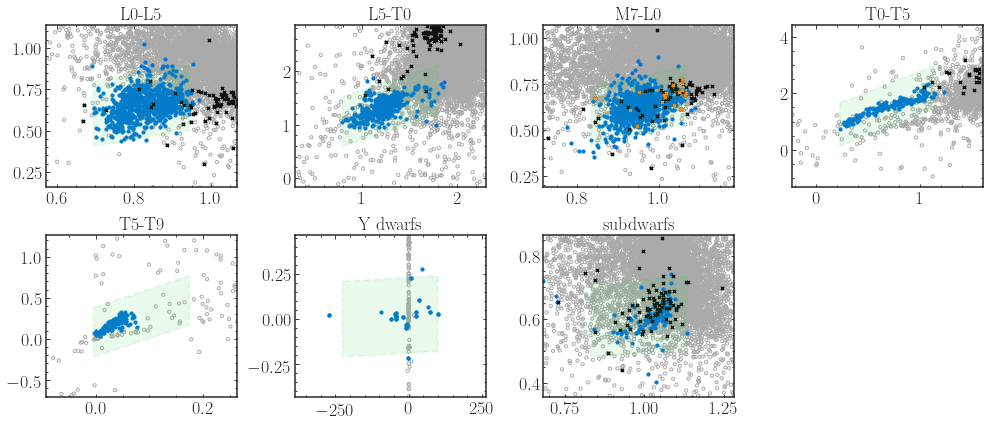

In [45]:
fig, ax=plt.subplots(nrows=2, ncols=4, figsize=(14, 6))

bxs=[]
for idx, k in enumerate(to_use.keys()):
    b=plot_index_box( k, to_use[k], np.concatenate(ax)[idx])
    bxs.append(b)
plt.tight_layout()
fig.delaxes(np.concatenate(ax)[-1])
#fig.delaxes(np.concatenate(ax)[-2])
plt.savefig(wisps.OUTPUT_FIGURES+'/index_index_plots.jpeg', bbox_inches='tight')

In [46]:
bx_dict={}
for b in bxs:
    bx_dict.update(b)

In [47]:
#invert to use
inv_to_use = {v: k for k, v in to_use.items()}

In [48]:
inv_to_use

{'L0-L5': 'H_2O-1/J-Cont H_2O-2/H_2O-1',
 'L5-T0': 'H_2O-1+H_2O-2/J-Cont H_2O-1+H_2O-2/H-Cont',
 'M7-L0': 'H_2O-1/J-Cont H_2O-2/J-Cont',
 'T0-T5': 'H_2O-1+H_2O-2/J-Cont H_2O-2+CH_4/J-Cont',
 'T5-T9': 'H_2O-2/J-Cont H_2O-1+CH_4/H-Cont',
 'Y dwarfs': 'H-cont/H_2O-2 H_2O-1+CH_4/H-Cont',
 'subdwarfs': 'H_2O-1/J-Cont H-cont/J-Cont'}

In [49]:
dt.shape

(12043, 26)

In [50]:
from tqdm import tqdm

In [51]:
ncandidates=[]
for spt_range in bx_dict.keys():
    idx_name=inv_to_use[spt_range]
    idx=crts[idx_name]
    s, bools=(bx_dict[spt_range])._select(np.array([dt[idx.xkey].values, dt[idx.ykey].values]))
    ncandidates.append(dt[bools])

In [52]:
candsss=(pd.concat(ncandidates).drop_duplicates(subset='grism_id'))

In [53]:
cands_dff.grism_id=cands_dff.grism_id.apply(lambda x: x.lower())

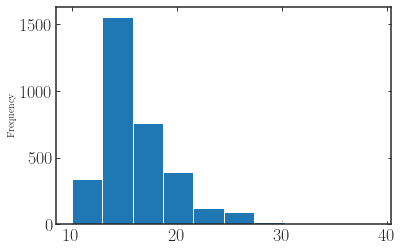

In [54]:
candsss.spt.plot(kind='hist')

In [55]:
len(candsss), len(candsss[candsss.grism_id.isin(cands_dff.grism_id) & (candsss.spt.apply(wisps.make_spt_number)>16)])

(3295, 33)

In [56]:
len(candsss[candsss.grism_id.isin(cands_dff.grism_id) & (candsss.spt.apply(wisps.make_spt_number)>19)])

6

In [57]:
candsss.to_pickle(wisps.OUTPUT_FILES+'/selected_by_indices.pkl')

In [58]:
def round_tuple(tpl, n=2):
    return round(tpl[0], n), round(tpl[1],n)

In [59]:
inv_to_use

{'L0-L5': 'H_2O-1/J-Cont H_2O-2/H_2O-1',
 'L5-T0': 'H_2O-1+H_2O-2/J-Cont H_2O-1+H_2O-2/H-Cont',
 'M7-L0': 'H_2O-1/J-Cont H_2O-2/J-Cont',
 'T0-T5': 'H_2O-1+H_2O-2/J-Cont H_2O-2+CH_4/J-Cont',
 'T5-T9': 'H_2O-2/J-Cont H_2O-1+CH_4/H-Cont',
 'Y dwarfs': 'H-cont/H_2O-2 H_2O-1+CH_4/H-Cont',
 'subdwarfs': 'H_2O-1/J-Cont H-cont/J-Cont'}

In [60]:
good_indices=[crts[x] for x in inv_to_use.values()]

In [61]:
for sindex, k in zip(good_indices, to_use.keys()):
   
    spt_range=to_use[k]
    bs=sindex.shapes
    bs=[x for x in bs if x.shape_name==spt_range]

    bx=bs[0]
    
    print (" {} & {} &  {} & {} & {} & {} & {} & {} & {}  & {} \\\ ".format(spt_range,sindex.xkey, sindex.ykey, 
                                                                           round_tuple(bx.vertices[0]), round_tuple(bx.vertices[1])
                                                                          , round_tuple(bx.vertices[2]), round_tuple(bx.vertices[3]),
                                                                          round(sindex.completeness[spt_range], 2), 
                                                                            round(sindex.contamination[spt_range], 3), 
                                                                           round(fp[spt_range], 2)))
    

 L0-L5 & H_2O-1/J-Cont &  H_2O-2/H_2O-1 & (0.7, 0.8) & (0.94, 0.89) & (0.94, 0.5) & (0.7, 0.41) & 0.98 & 0.03  & 0.97 \\ 
 L5-T0 & H_2O-1+H_2O-2/J-Cont &  H_2O-1+H_2O-2/H-Cont & (0.8, 1.53) & (1.8, 2.11) & (1.8, 1.18) & (0.8, 0.6) & 0.98 & 0.075  & 0.99 \\ 
 M7-L0 & H_2O-1/J-Cont &  H_2O-2/J-Cont & (0.83, 0.73) & (1.07, 0.85) & (1.07, 0.53) & (0.83, 0.41) & 0.97 & 0.082  & 0.94 \\ 
 T0-T5 & H_2O-1+H_2O-2/J-Cont &  H_2O-2+CH_4/J-Cont & (0.23, 1.66) & (1.15, 2.99) & (1.15, 1.46) & (0.23, 0.12) & 0.98 & 0.007  & 0.98 \\ 
 T5-T9 & H_2O-2/J-Cont &  H_2O-1+CH_4/H-Cont & (-0.0, 0.38) & (0.17, 0.77) & (0.17, 0.17) & (-0.0, -0.22) & 0.98 & 0.015  & 1.0 \\ 
 Y dwarfs & H-cont/H_2O-2 &  H_2O-1+CH_4/H-Cont & (-225.74, 0.21) & (99.91, 0.24) & (99.91, -0.18) & (-225.74, -0.21) & 0.85 & 0.004  & 1.0 \\ 
 subdwarfs & H_2O-1/J-Cont &  H-cont/J-Cont & (0.83, 0.71) & (1.13, 0.74) & (1.13, 0.51) & (0.83, 0.48) & 0.94 & 0.149  & 1.0 \\ 


In [ ]:
all_stuff=pd.read_hdf(wisps.COMBINED_PHOTO_SPECTRO_FILE, key='all_phot_spec_data')

In [ ]:
len(all_stuff)

In [ ]:
len(stars)/len(all_stuff)

In [ ]:
stars_with_snr= stars[(stars.snr1>=3.)]

In [ ]:
len(stars_with_snr)/len(stars), len(stars_with_snr)/len(all_stuff)

In [ ]:
stars_with_ftest=(stars[(stars.f_test< 0.4) &(stars.snr1>=3.)])

In [ ]:
len(stars_with_ftest), len(stars_with_ftest)/len(stars_with_snr), len(stars_with_ftest)/len(stars),  len(stars_with_ftest)/len(all_stuff)

In [ ]:
len(cands[cands.spt>=17])

In [ ]:
plt.scatter(cands_dff.f_test, cands_dff.snr2.apply(np.log10), c=cands_dff.spt, cmap='viridis')

In [ ]:
spx=wisps.datasets['spex']

In [ ]:
len(spx[spx.spt>=17])

In [ ]:
len(wisps.datasets['spex'])

In [ ]:
len(comb)

In [ ]:
len(dt)/len(comb0)

In [ ]:
(comb[comb.snr2>3.]).shape[0]/len(comb0)